# Titanic

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv('Titanic Data/train.csv')

## Tratamento

### Escolhendo as colunas

In [3]:
# Vamos ver as variáveis disponíveis
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

### Tratando valores nulos

In [5]:
# Quantos valores nulos temos por atributo
data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
# Vamos remover Cabin por ter muitos valores nulos
data.drop(['Cabin'], axis=1, inplace=True)

In [7]:
# Vamos analisar a váriavel Age, para estudar a melhor forma de preencher valores nulos
data['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Distribuição da idade dos passageiros')

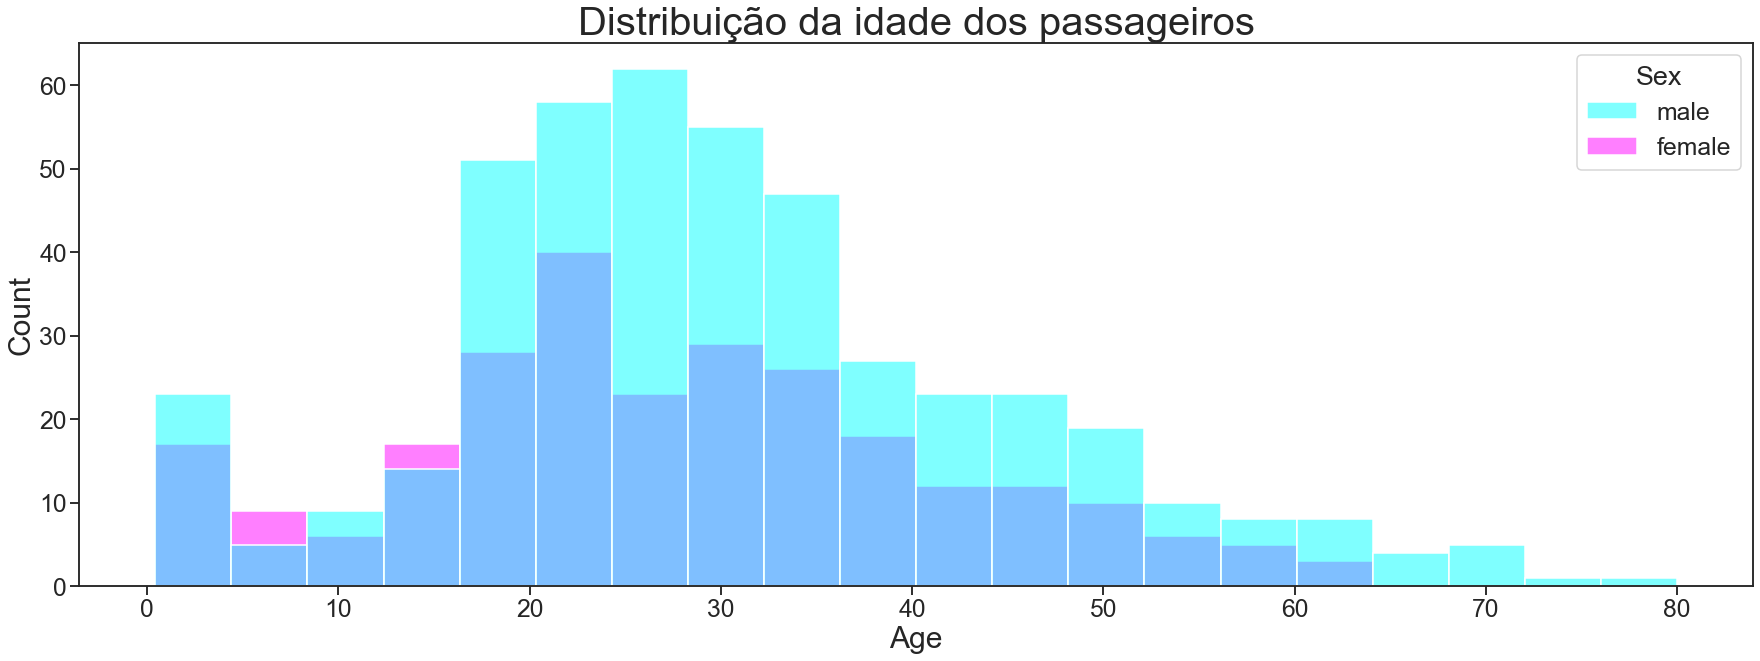

In [9]:
# Sua distribuição também

sns.set_style("ticks")
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(30, 10))
palette = sns.color_palette(['cyan', 'magenta'])
plot = sns.histplot(data=data, x="Age", hue ='Sex', palette=palette)
plot.set_xlabel("Age", fontsize=30) 
plot.set_ylabel("Count", fontsize=30)
plt.title("Distribuição da idade dos passageiros", fontsize=40)

In [10]:
# Vamos preencher com a média
data['Age'].fillna(data['Age'].mean(), inplace=True)

In [11]:
# Sobraram poucos valores nulos, então vamos remover essas entradas
data.dropna(inplace=True)

### Tratamento de tipo

In [12]:
# Verificando o tipo de cada variável
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [13]:
data['Sex'].unique()

array(['male', 'female'], dtype=object)

In [14]:
replace_gender = lambda s: 0 if s == 'male' else 1

data['Sex'] = data['Sex'].apply(replace_gender)

In [15]:
data['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [16]:
replace_embarked = lambda e: 0 if e == 'Q' else 1 if e == 'S' else 2

data['Embarked'] = data['Embarked'].apply(replace_embarked)

### Análise de correlação

<AxesSubplot:>

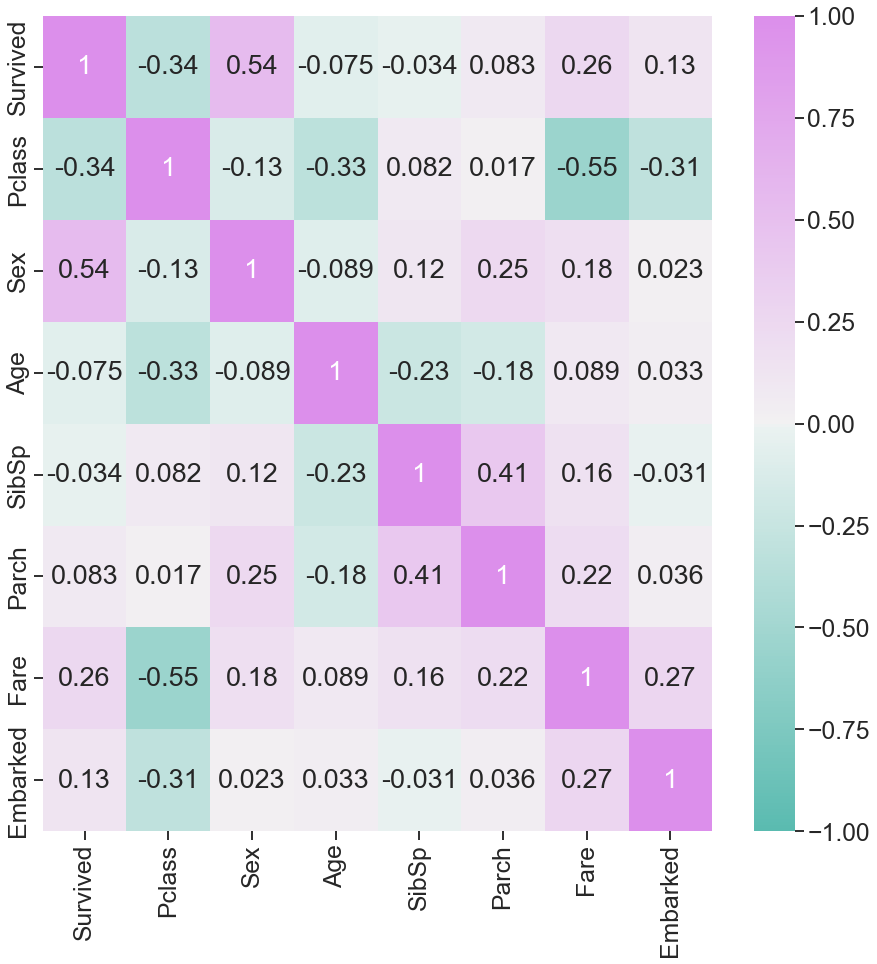

In [17]:
# matriz de correlação
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(15, 15))
palette = sns.diverging_palette(180,300, l=70, as_cmap=True)
sns.heatmap(data.corr(), annot=True, cmap=palette, vmin=-1, vmax=1)

### Normalização

In [18]:
data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,0.350956,29.653446,0.524184,0.382452,32.096681,1.102362
std,0.486260,0.834700,0.477538,12.968366,1.103705,0.806761,49.697504,0.515181
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800,1.000000
50%,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


In [19]:
# Normalizaremos as variáveis não binárias
normalize = lambda x: (x - x.min()) / (x.max() - x.min())
data = data.apply(normalize)

In [20]:
data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,0.655793,0.350956,0.367347,0.065523,0.063742,0.062649,0.551181
std,0.486260,0.417350,0.477538,0.162960,0.137963,0.134460,0.097003,0.257590
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.000000,0.271174,0.000000,0.000000,0.015412,0.500000
50%,0.000000,1.000000,0.000000,0.367921,0.000000,0.000000,0.028213,0.500000
75%,1.000000,1.000000,1.000000,0.434531,0.125000,0.000000,0.060508,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Preparação

### Dataset e Dataloader

In [21]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [22]:
X_data = data.drop('Survived', axis=1).values
y_data = data['Survived'].values

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [24]:
class TitanicDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.float)

In [25]:
BATCH_SIZE = 32

train_dataloader = DataLoader(TitanicDataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(TitanicDataset(X_val, y_val), shuffle=True, batch_size=BATCH_SIZE)

device = ( "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu")

## Arquitetura

In [26]:
import torch.nn as nn

In [27]:
class TitanicNN(nn.Module):
    def __init__(self):
        super(TitanicNN, self).__init__()
        self.fc1 = nn.Linear(in_features=7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)
        self.dropout = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [28]:
model = TitanicNN()

loss_fn = nn.BCELoss()
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Treinamento

In [29]:
def train(dataloader):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = y.type(torch.FloatTensor)
        X, y = X.to(device), y.to(device)

        pred = model(X)
        pred = pred.squeeze(1)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return loss

In [30]:
def test(dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() 
    test_loss, correct = 0, 0
    with torch.no_grad(): 
        for X, y in dataloader:
            y = y.type(torch.FloatTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = pred.squeeze(1)
            test_loss += loss_fn(pred, y).item()

            correct += (pred.round() == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss

In [31]:
train_losses = []
test_losses = []
EPOCHS = 32
for t in range(EPOCHS):
    print(f'Epoch {t+1} -------------------------------')
    
    print('Train')
    train_losses.append(train(train_dataloader))
    
    print('Test')
    test_losses.append(test(val_dataloader))

Epoch 1 -------------------------------
Train
Test
Accuracy: 67.4%, Avg loss: 0.610750 

Epoch 2 -------------------------------
Train


/tmp/ipykernel_57912/1549261356.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.float)


Test
Accuracy: 80.3%, Avg loss: 0.513807 

Epoch 3 -------------------------------
Train
Test
Accuracy: 79.8%, Avg loss: 0.456396 

Epoch 4 -------------------------------
Train
Test
Accuracy: 80.3%, Avg loss: 0.436534 

Epoch 5 -------------------------------
Train
Test
Accuracy: 80.3%, Avg loss: 0.438451 

Epoch 6 -------------------------------
Train
Test
Accuracy: 80.9%, Avg loss: 0.441912 

Epoch 7 -------------------------------
Train
Test
Accuracy: 80.9%, Avg loss: 0.442670 

Epoch 8 -------------------------------
Train
Test
Accuracy: 80.3%, Avg loss: 0.424436 

Epoch 9 -------------------------------
Train
Test
Accuracy: 81.5%, Avg loss: 0.464183 

Epoch 10 -------------------------------
Train
Test
Accuracy: 82.6%, Avg loss: 0.440883 

Epoch 11 -------------------------------
Train
Test
Accuracy: 80.9%, Avg loss: 0.434143 

Epoch 12 -------------------------------
Train
Test
Accuracy: 80.9%, Avg loss: 0.424701 

Epoch 13 -------------------------------
Train
Test
Accuracy: 81

## Métricas do modelo

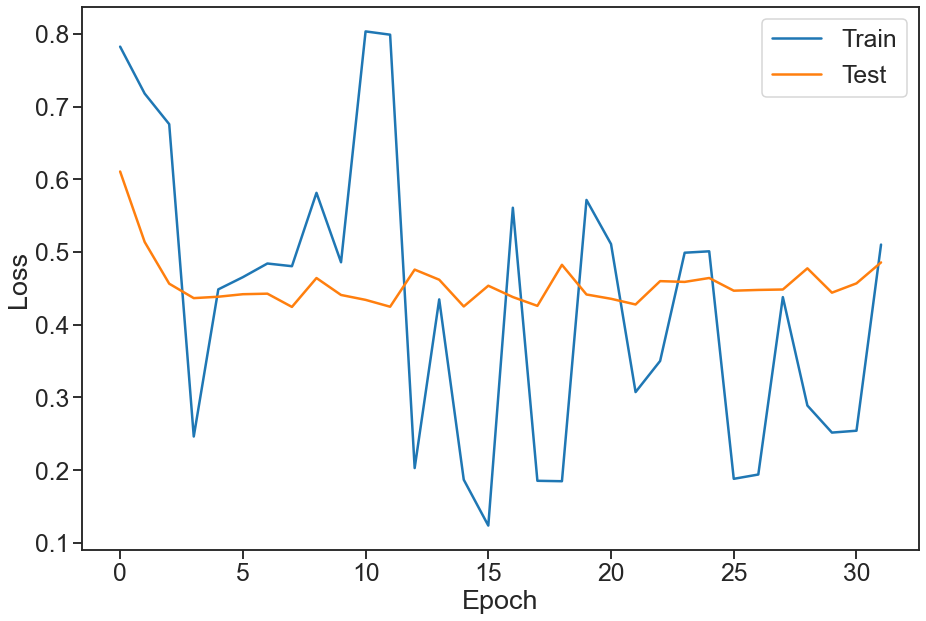

In [43]:
train_losses = [l.item() for l in train_losses]
test_losses = [l for l in test_losses]

## Plotando as curvas de treino e validação
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix

model.eval()
with torch.no_grad():
    y_pred = model(torch.FloatTensor(X_val).to(device)).squeeze(1).round().cpu().numpy()

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 81.46%


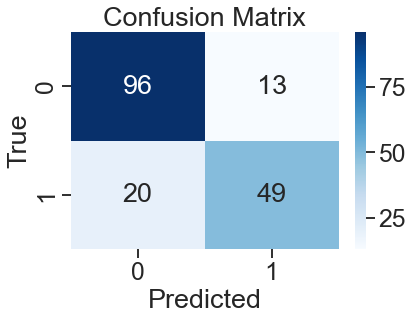

In [47]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()